Loading Bank Account Fraud Dataset...
Dataset shape: (1000000, 32)
Fraud rate: 1.10%

Encoding 5 categorical features...
  payment_type: 5 classes
  employment_status: 7 classes
  housing_status: 7 classes
  source: 2 classes
  device_os: 5 classes

Features: 31

Data splits:
  Train: 700,400 samples (1.10% fraud)
  Val:   149,600 samples (1.10% fraud)
  Test:  150,000 samples (1.10% fraud)

Sample batch fraud rate: 48.4% (target: ~50%)

Device: cuda
Model parameters: 52,353
Input features: 31

Starting training...
Epoch | Train Loss |   Val Loss |       F1 |   Recall |  Precision
----------------------------------------------------------------------
    1 |     0.1227 |     0.0401 |   0.0562 |   0.8339 |     0.0291
      ✓ New best model saved (F1: 0.0562)
    2 |     0.0596 |     0.0504 |   0.0503 |   0.9048 |     0.0259
    3 |     0.0538 |     0.0446 |   0.0545 |   0.9024 |     0.0281
    4 |     0.0505 |     0.0440 |   0.0548 |   0.8885 |     0.0283
    5 |     0.0476 |     0.0414

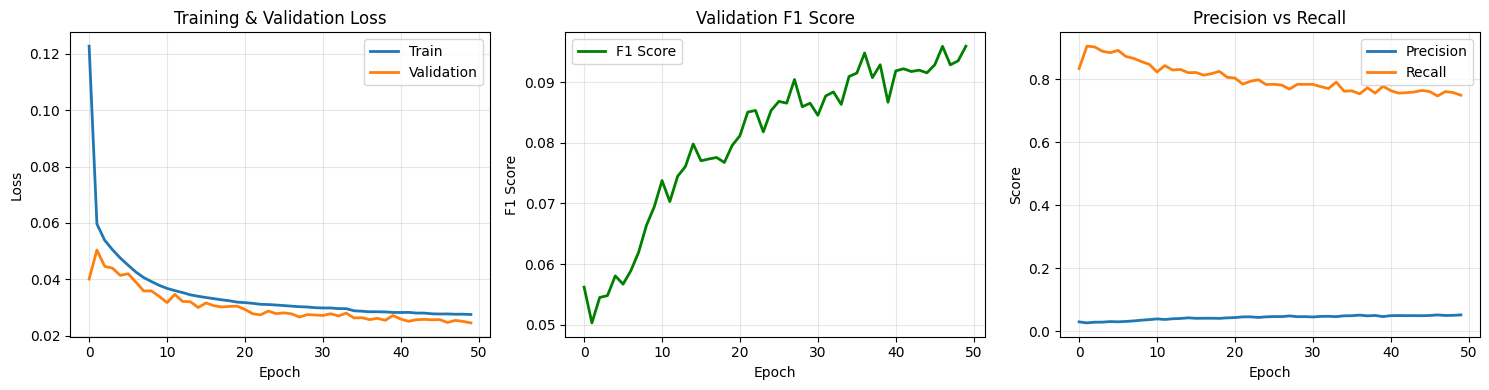

✓ Training curves saved

TEST SET EVALUATION

Probability range: 0.0000 to 0.9051
Probability mean: 0.2291
Probability std: 0.2215

THRESHOLD OPTIMIZATION

Thresh   Precision    Recall     F1         TP       FP         FN      
---------------------------------------------------------------------------
0.1      0.0174       0.9661     0.0341     1598     90474      56      
0.2      0.0262       0.9021     0.0509     1492     55436      162     
0.3      0.0331       0.8585     0.0638     1420     41425      234     
0.4      0.0409       0.8096     0.0778     1339     31414      315     
0.5      0.0515       0.7491     0.0964     1239     22817      415     
0.6      0.0666       0.6681     0.1211     1105     15484      549     
0.7      0.1023       0.5242     0.1712     867      7606       787     
0.8      0.3094       0.0992     0.1502     164      366        1490    
0.9      1.0000       0.0006     0.0012     1        0          1653    

✓ Optimal Threshold: 0.7
  Precision:

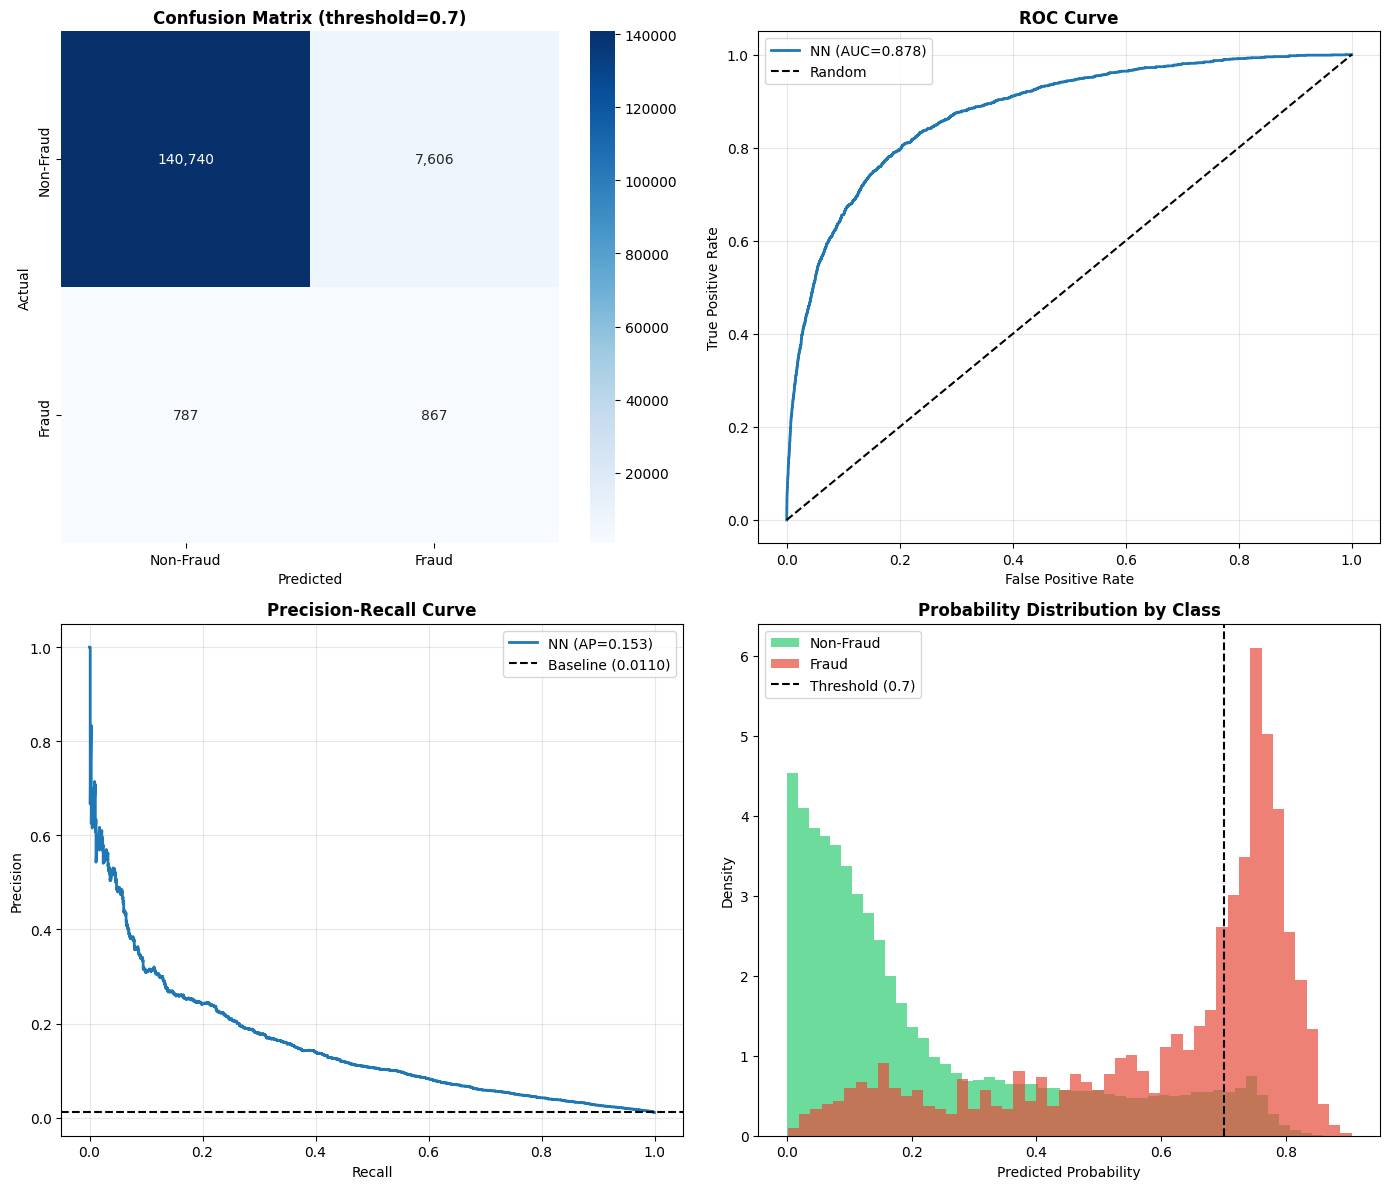


NEURAL NETWORK RESULTS SUMMARY - SECONDARY DATASET

Model: Neural Network
Dataset: Secondary (Bank Account Fraud)

Performance Metrics:
- ROC-AUC: 0.8776
- PR-AUC: 0.1526
- Best F1: 0.1712
- Precision: 0.1023 (10.2%)
- Recall: 0.5242 (52.4%)
- Optimal Threshold: 0.7

Training:
- Time: 201.6 seconds

Files Saved:
- Model: ../models/secondary/nn_best_model.pth
- Scaler: ../models/secondary/scaler.pkl
- Results: ../models/secondary/nn_results.pkl
- Training curves: ../outputs/secondary/neural_network/training_curves.png
- Evaluation: ../outputs/secondary/neural_network/evaluation_results.png



In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# ===== 1. LOAD DATA =====
print("Loading Bank Account Fraud Dataset...")
df = pd.read_csv('../data/secondary/Base.csv')

target_col = 'fraud_bool'
print(f"Dataset shape: {df.shape}")
print(f"Fraud rate: {df[target_col].mean()*100:.2f}%")

# ===== 2. ENCODE CATEGORICAL FEATURES =====
categorical_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

print(f"\nEncoding {len(categorical_cols)} categorical features...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} classes")

# ===== 3. PREPARE FEATURES AND TARGET =====
X = df.drop(target_col, axis=1)
y = df[target_col]

print(f"\nFeatures: {X.shape[1]}")

# ===== 4. TRAIN/VAL/TEST SPLIT =====
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nData splits:")
print(f"  Train: {X_train.shape[0]:,} samples ({y_train.mean()*100:.2f}% fraud)")
print(f"  Val:   {X_val.shape[0]:,} samples ({y_val.mean()*100:.2f}% fraud)")
print(f"  Test:  {X_test.shape[0]:,} samples ({y_test.mean()*100:.2f}% fraud)")

# ===== 5. SCALE FEATURES =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save artifacts
with open('../models/secondary/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('../models/secondary/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# ===== 6. PYTORCH DATASET =====
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values if hasattr(y, 'values') else y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ===== 7. WEIGHTED SAMPLER =====
y_train_np = y_train.values
class_counts = np.bincount(y_train_np)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train_np]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create datasets and loaders
train_dataset = FraudDataset(X_train_scaled, y_train)
val_dataset = FraudDataset(X_val_scaled, y_val)
test_dataset = FraudDataset(X_test_scaled, y_test)

BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Verify balanced batches
X_batch, y_batch = next(iter(train_loader))
print(f"\nSample batch fraud rate: {y_batch.mean()*100:.1f}% (target: ~50%)")

# ===== 8. MODEL ARCHITECTURE =====
class FraudDetectionNet(nn.Module):
    def __init__(self, input_size, fraud_rate=0.011):
        super(FraudDetectionNet, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.output = nn.Linear(32, 1)
        self._init_weights(fraud_rate)

    def _init_weights(self, fraud_rate):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        prior_logit = np.log(fraud_rate / (1 - fraud_rate))
        nn.init.constant_(self.output.bias, prior_logit)

    def forward(self, x):
        x = self.network(x)
        return self.output(x)

# ===== 9. FOCAL LOSS =====
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-BCE_loss)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        focal_weight = alpha_t * (1 - pt) ** self.gamma
        loss = focal_weight * BCE_loss
        return loss.mean()

# ===== 10. INITIALIZE MODEL =====
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fraud_rate = y_train.mean()

model = FraudDetectionNet(input_size=X_train.shape[1], fraud_rate=fraud_rate).to(DEVICE)
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

print(f"\nDevice: {DEVICE}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input features: {X_train.shape[1]}")

# ===== 11. TRAINING LOOP =====
EPOCHS = 50
PATIENCE = 10

train_losses = []
val_losses = []
val_f1_scores = []
val_recalls = []
val_precisions = []

best_f1 = 0
patience_counter = 0

print("\nStarting training...")
print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>10} | {'F1':>8} | {'Recall':>8} | {'Precision':>10}")
print("-" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= len(val_loader)

    # Metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    f1 = f1_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    precision = precision_score(all_labels, all_preds, zero_division=0)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(f1)
    val_recalls.append(recall)
    val_precisions.append(precision)

    scheduler.step(f1)

    print(f"{epoch+1:>5} | {train_loss:>10.4f} | {val_loss:>10.4f} | {f1:>8.4f} | {recall:>8.4f} | {precision:>10.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), '../models/secondary/nn_best_model.pth')
        print(f"      ✓ New best model saved (F1: {f1:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

training_time = time.time() - start_time
print(f"\n✓ Training complete in {training_time:.1f} seconds")
print(f"Best F1: {best_f1:.4f}")

# ===== 12. PLOT TRAINING CURVES =====
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(val_f1_scores, label='F1 Score', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Validation F1 Score')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(val_precisions, label='Precision', linewidth=2)
axes[2].plot(val_recalls, label='Recall', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Score')
axes[2].set_title('Precision vs Recall')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/secondary/neural_network/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

# ===== 13. EVALUATE ON TEST SET =====
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

model.load_state_dict(torch.load('../models/secondary/nn_best_model.pth', map_location=DEVICE))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch).squeeze()
        probs = torch.sigmoid(outputs)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y_batch.numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print(f"\nProbability range: {all_probs.min():.4f} to {all_probs.max():.4f}")
print(f"Probability mean: {all_probs.mean():.4f}")
print(f"Probability std: {all_probs.std():.4f}")

# ===== 14. THRESHOLD OPTIMIZATION =====
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for thresh in thresholds:
    preds = (all_probs >= thresh).astype(int)

    tp = ((preds == 1) & (all_labels == 1)).sum()
    fp = ((preds == 1) & (all_labels == 0)).sum()
    fn = ((preds == 0) & (all_labels == 1)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    results.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

print(f"\n{'Thresh':<8} {'Precision':<12} {'Recall':<10} {'F1':<10} {'TP':<8} {'FP':<10} {'FN':<8}")
print("-" * 75)
for r in results:
    print(f"{r['threshold']:<8.1f} {r['precision']:<12.4f} {r['recall']:<10.4f} {r['f1']:<10.4f} {r['tp']:<8} {r['fp']:<10} {r['fn']:<8}")

best_result = max(results, key=lambda x: x['f1'])
print(f"\n✓ Optimal Threshold: {best_result['threshold']}")
print(f"  Precision: {best_result['precision']:.4f}")
print(f"  Recall: {best_result['recall']:.4f}")
print(f"  F1: {best_result['f1']:.4f}")

# ===== 15. FINAL METRICS =====
optimal_preds = (all_probs >= best_result['threshold']).astype(int)

roc_auc = roc_auc_score(all_labels, all_probs)
pr_auc = average_precision_score(all_labels, all_probs)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, optimal_preds, target_names=['Non-Fraud', 'Fraud'], digits=4))

# ===== 16. VISUALIZATIONS =====
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion Matrix
cm = confusion_matrix(all_labels, optimal_preds)
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_title(f'Confusion Matrix (threshold={best_result["threshold"]})', fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'NN (AUC={roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision-Recall Curve
precisions_curve, recalls_curve, _ = precision_recall_curve(all_labels, all_probs)
axes[1, 0].plot(recalls_curve, precisions_curve, linewidth=2, label=f'NN (AP={pr_auc:.3f})')
axes[1, 0].axhline(y=all_labels.mean(), color='k', linestyle='--', label=f'Baseline ({all_labels.mean():.4f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Probability Distribution
axes[1, 1].hist(all_probs[all_labels == 0], bins=50, alpha=0.7, label='Non-Fraud', color='#2ecc71', density=True)
axes[1, 1].hist(all_probs[all_labels == 1], bins=50, alpha=0.7, label='Fraud', color='#e74c3c', density=True)
axes[1, 1].axvline(x=best_result['threshold'], color='black', linestyle='--', label=f'Threshold ({best_result["threshold"]})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distribution by Class', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../outputs/secondary/neural_network/evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== 17. SAVE RESULTS =====
nn_results = {
    'model': 'Neural Network',
    'dataset': 'Secondary (Bank Account Fraud)',
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'best_f1': best_result['f1'],
    'precision': best_result['precision'],
    'recall': best_result['recall'],
    'optimal_threshold': best_result['threshold'],
    'training_time': training_time
}

with open('../models/secondary/nn_results.pkl', 'wb') as f:
    pickle.dump(nn_results, f)

print("\n" + "="*70)
print("NEURAL NETWORK RESULTS SUMMARY - SECONDARY DATASET")
print("="*70)
print(f"""
Model: Neural Network
Dataset: Secondary (Bank Account Fraud)

Performance Metrics:
- ROC-AUC: {roc_auc:.4f}
- PR-AUC: {pr_auc:.4f}
- Best F1: {best_result['f1']:.4f}
- Precision: {best_result['precision']:.4f} ({best_result['precision']*100:.1f}%)
- Recall: {best_result['recall']:.4f} ({best_result['recall']*100:.1f}%)
- Optimal Threshold: {best_result['threshold']}

Training:
- Time: {training_time:.1f} seconds

Files Saved:
- Model: ../models/secondary/nn_best_model.pth
- Scaler: ../models/secondary/scaler.pkl
- Results: ../models/secondary/nn_results.pkl
- Training curves: ../outputs/secondary/neural_network/training_curves.png
- Evaluation: ../outputs/secondary/neural_network/evaluation_results.png
""")